In [ ]:
import cv2 as cv
import numpy as np

def rescale(frame, scale=0.75):
    """Reescala el frame manteniendo la proporción (ahora a 75% por defecto)."""
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[0] * scale)
    return cv.resize(frame, (width, height), interpolation=cv.INTER_AREA)

video = cv.VideoCapture('trafico.mp4')
if not video.isOpened():
    print("Error: No se pudo abrir el video.")
    exit()

object_detector = cv.createBackgroundSubtractorMOG2(history=500, varThreshold=8, detectShadows=True)

tracking_objects = {}  # {ID: (cx, cy)}
next_car_id = 0
MIN_CONTOUR_AREA = 50  # MUY BAJO: Captura objetos tan pequeños como 7x7 píxeles.
MAX_DISTANCE = 70      # Distancia euclídea máxima para considerarse el mismo objeto.

while True:
    ret, frame = video.read()
    if not ret:
        break

    frame = rescale(frame)
    
    mask = object_detector.apply(frame)

    kernel = np.ones((3, 3), np.uint8) 
    
    _, mask = cv.threshold(mask, 250, 255, cv.THRESH_BINARY)
    
    mask = cv.medianBlur(mask, 3) 

    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations=2) 
    
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=1) 

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    current_objects = {}

    for contour in contours:
        area = cv.contourArea(contour)

        if area < MIN_CONTOUR_AREA:
            continue

        x, y, w, h = cv.boundingRect(contour)
        cx, cy = x + w // 2, y + h // 2  # Centroide
        
        found_match = False
        car_id_to_assign = -1

        for car_id, prev_center in tracking_objects.items():
            prev_x, prev_y = prev_center
            distance = np.sqrt((cx - prev_x)**2 + (cy - prev_y)**2)

            if distance < MAX_DISTANCE:
                car_id_to_assign = car_id
                found_match = True
                break  
        
        if not found_match:
            car_id_to_assign = next_car_id
            next_car_id += 1
            
        current_objects[car_id_to_assign] = (cx, cy)
        
        cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  
        cv.putText(frame, f'ID: {car_id_to_assign}', (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

    tracking_objects = current_objects
    
    cv.imshow('Tracking de Todos los Objetos en Movimiento', frame)
    cv.imshow('Mascara de Movimiento Optimizada', mask)

    if cv.waitKey(10) & 0xFF == ord('d'):
        break

video.release()
cv.destroyAllWindows()

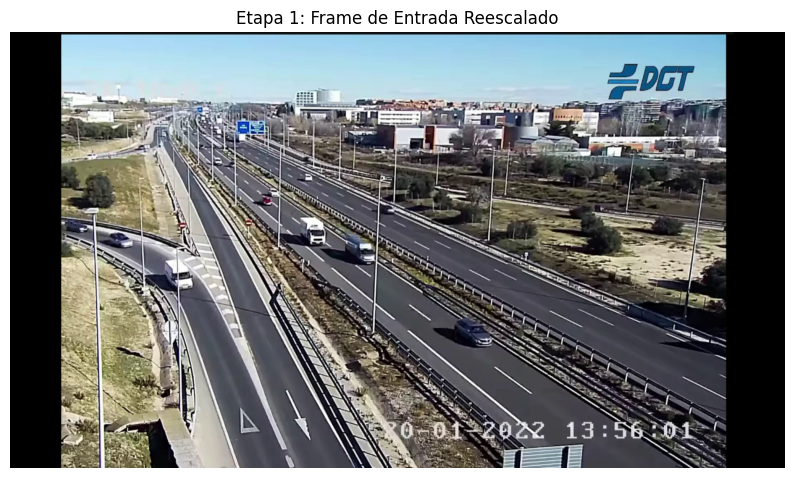

Dimensiones del frame reescalado: (810, 1440, 3)


In [40]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt 

def rescale(frame, scale=0.75):
    """Reescala el frame manteniendo la proporción."""
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[0] * scale)
    return cv.resize(frame, (width, height), interpolation=cv.INTER_AREA)

video = cv.VideoCapture('trafico.mp4')
if not video.isOpened():
    print("Error: No se pudo abrir el video.")
    exit()

ret, frame = video.read()
if not ret:
    print("Error al leer el primer frame.")
    exit()

frame_rescaled = rescale(frame)

plt.figure(figsize=(10, 6))
plt.imshow(cv.cvtColor(frame_rescaled, cv.COLOR_BGR2RGB))
plt.title("Etapa 1: Frame de Entrada Reescalado")
plt.axis('off')
plt.show()

video.set(cv.CAP_PROP_POS_FRAMES, 0)
print(f"Dimensiones del frame reescalado: {frame_rescaled.shape}")

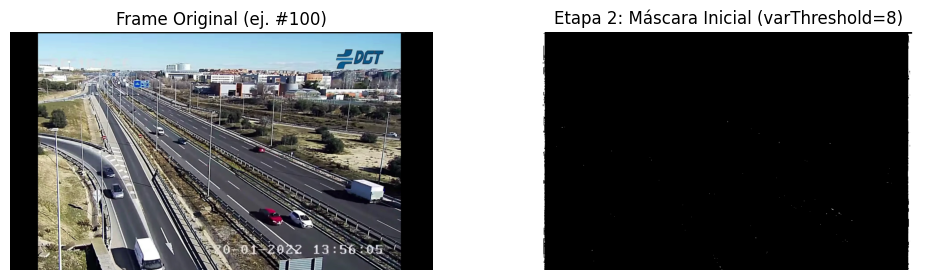

La máscara cruda contiene las sombras (gris), el fondo (negro) y el movimiento (blanco).


In [41]:
# Detector de fondo (MOG2) - Alta sensibilidad
object_detector = cv.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=True)

# Leer un frame de ejemplo para la máscara (e.g., frame 100)
video.set(cv.CAP_PROP_POS_FRAMES, 100)
ret, frame = video.read()
frame = rescale(frame)

# Generar la máscara
mask_initial = object_detector.apply(frame)

# Visualizar la Máscara Inicial
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
plt.title("Frame Original (ej. #100)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_initial, cmap='gray')
plt.title(f"Etapa 2: Máscara Inicial (varThreshold=8)")
plt.axis('off')

plt.show()
print("La máscara cruda contiene las sombras (gris), el fondo (negro) y el movimiento (blanco).")

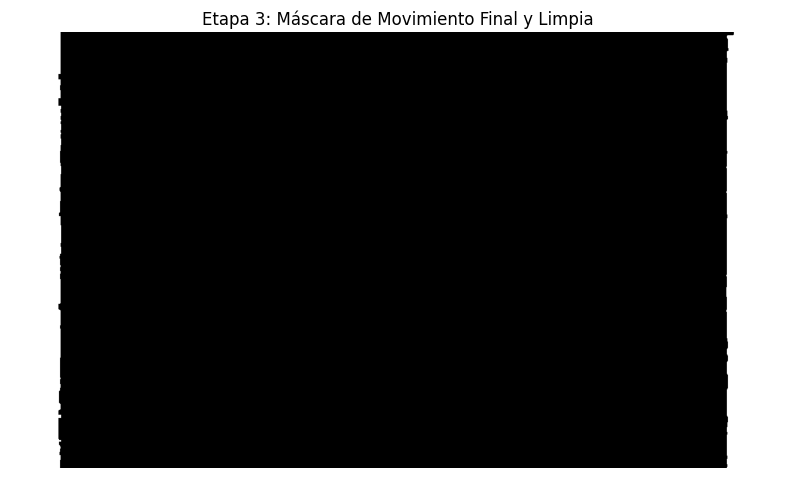

In [42]:
# Reutilizar la mask_initial de la Etapa 2

# 3.1. Eliminación de Sombra y Umbralización
# Solo dejamos los píxeles blancos (movimiento)
_, mask_binary = cv.threshold(mask_initial, 250, 255, cv.THRESH_BINARY)

# 3.2. Limpieza y Optimización
kernel = np.ones((3, 3), np.uint8) 

# Median Blur (Elimina ruido fino)
mask_filtered = cv.medianBlur(mask_binary, 3) 

# Cierre (Rellena huecos internos)
mask_filtered = cv.morphologyEx(mask_filtered, cv.MORPH_CLOSE, kernel, iterations=2) 

# Apertura (Elimina ruido residual)
mask_filtered = cv.morphologyEx(mask_filtered, cv.MORPH_OPEN, kernel, iterations=1) 

# Visualizar la Máscara Final
plt.figure(figsize=(10, 6))
plt.imshow(mask_filtered, cmap='gray')
plt.title("Etapa 3: Máscara de Movimiento Final y Limpia")
plt.axis('off')
plt.show()

In [44]:
MIN_CONTOUR_AREA = 500

# Encontrar contornos
contours, _ = cv.findContours(mask_filtered, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Crear una imagen en color para dibujar los contornos
frame_contours = frame.copy() 

valid_contours_count = 0
for contour in contours:
    area = cv.contourArea(contour)
    
    if area < MIN_CONTOUR_AREA:
        continue
    
    # Dibujar contornos válidos en amarillo
    cv.drawContours(frame_contours, [contour], -1, (0, 255, 255), 2)
    valid_contours_count += 1

# Visualizar los Contornos Detectados
plt.figure(figsize=(10, 6))
plt.imshow(cv.cvtColor(frame_contours, cv.COLOR_BGR2RGB))
plt.title(f"Etapa 4: Contornos Válidos Detectados (Área > {MIN_CONTOUR_AREA})")
plt.axis('off')
plt.show()
print(f"Contornos detectados válidos en este frame: {valid_contours_count}")

AttributeError: 'NoneType' object has no attribute 'copy'

In [99]:
# --- Resetear y redefinir variables para el bucle completo ---
video.set(cv.CAP_PROP_POS_FRAMES, 0) # Volver al inicio
object_detector = cv.createBackgroundSubtractorMOG2(history=500, varThreshold=8, detectShadows=True) 
tracking_objects = {}
next_car_id = 0
MIN_CONTOUR_AREA = 50 
MAX_DISTANCE = 70
kernel = np.ones((3, 3), np.uint8) 

while True:
    ret, frame = video.read()
    if not ret:
        break

    frame = rescale(frame)
    
    # --- 1. Generación y Limpieza de Máscara (Etapas 2 y 3) ---
    mask = object_detector.apply(frame)
    _, mask = cv.threshold(mask, 250, 255, cv.THRESH_BINARY)
    mask = cv.medianBlur(mask, 3) 
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations=2) 
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=1) 

    # --- 2. Detección de Contornos (Etapa 4) ---
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    current_objects = {}

    for contour in contours:
        if cv.contourArea(contour) < MIN_CONTOUR_AREA:
            continue

        x, y, w, h = cv.boundingRect(contour)
        cx, cy = x + w // 2, y + h // 2
        
        # --- 3. Tracking por Centroides ---
        found_match = False
        car_id_to_assign = -1

        for car_id, prev_center in tracking_objects.items():
            distance = np.sqrt((cx - prev_center[0])**2 + (cy - prev_center[1])**2)
            if distance < MAX_DISTANCE:
                car_id_to_assign = car_id
                found_match = True
                break  
        
        if not found_match:
            car_id_to_assign = next_car_id
            next_car_id += 1
            
        current_objects[car_id_to_assign] = (cx, cy)
        
        # --- 4. Visualización Final (Contorno Verde + ID) ---
        cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  
        cv.putText(frame, f'ID: {car_id_to_assign}', (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

    tracking_objects = current_objects
    
    cv.imshow('Etapa 5: Tracking Final', frame)
    cv.imshow('Máscara Optimizada', mask)

    if cv.waitKey(10) & 0xFF == ord('d'):
        break

video.release()
cv.destroyAllWindows()

In [50]:
import cv2
import numpy as np

# ------------------------- CONFIG ----------------------------

def rescale(frame, scale=0.6):
    w = int(frame.shape[1] * scale)
    h = int(frame.shape[0] * scale)
    return cv2.resize(frame, (w, h), interpolation=cv2.INTER_AREA)

def classify_vehicle(w, h, area):
    aspect_ratio = w / h
    if area < 100:
        return "Motocicleta"
    if area > 450:
        if aspect_ratio > 2.0:
            return "Camion"
        if aspect_ratio < 1.4 and h > w:
            return "Autobus"
    return "Turismo"


cap = cv2.VideoCapture('trafico.mp4')
if not cap.isOpened():
    print("Error: No se pudo abrir el video.")
    exit()

FPS = cap.get(cv2.CAP_PROP_FPS)
REQUIRED_CONFIRM_FRAMES = int(FPS * 1.0)

object_detector = cv2.createBackgroundSubtractorMOG2(
    history=250,
    varThreshold=32,
    detectShadows=True
)

# --- Estabilización inicial ---
for _ in range(150):
    ret, frame = cap.read()
    if not ret:
        break
    frame_s = rescale(frame)
    gray = cv2.cvtColor(frame_s, cv2.COLOR_BGR2GRAY)
    object_detector.apply(gray)

tracking_objects = {}
tracking_confirmation = {}
car_ids_counted = set()

vehicle_counts = {
    "Turismo":0,
    "Camion":0,
    "Autobus":0,
    "Motocicleta":0,
    "Total":0
}

# 🟢 NUEVOS CONTADORES DE DIRECCIÓN
north_count = 0   # dirección norte (suben)
south_count = 0   # dirección sur (bajan)
direction_counted = set()  # para evitar doble conteo direccional

next_car_id = 0

MIN_AREA_BLOB = 100
MAX_DISTANCE = 80
kernel_morph = np.ones((3, 3), np.uint8)
MIN_W = 10
MIN_H = 10
MIN_ASPECT_RATIO = 0.2
MAX_ASPECT_RATIO = 5.0

# ------------------ LÍNEAS DE CONTEO -------------------------

LINE_V1_P1 = (250, 400)
LINE_V1_P2 = (500, 300)

# Línea roja final
LINE_V2_P1 = (600, 350)
LINE_V2_P2 = (850, 250)

COUNT_THRESHOLD = 5

# ------------------------ BUCLE PRINCIPAL --------------------

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_s = rescale(frame)
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC)

    gray = cv2.cvtColor(frame_s, cv2.COLOR_BGR2GRAY)

    # -------------------- ETAPA A - Máscara cruda --------------------
    image_mask = object_detector.apply(gray, learningRate=0.003)

    image_mask[image_mask == 127] = 0
    image_mask = cv2.medianBlur(image_mask, 5)

    cv2.imshow("ETAPA A: Mascara Cruda", image_mask)

    # -------------------- ETAPA B - Binarizado ------------------------
    _, image_bin = cv2.threshold(image_mask, 200, 255, cv2.THRESH_BINARY)

    image_bin = cv2.morphologyEx(image_bin, cv2.MORPH_OPEN, kernel_morph, iterations=1)
    image_bin = cv2.morphologyEx(image_bin, cv2.MORPH_CLOSE, kernel_morph, iterations=1)

    cv2.imshow("ETAPA B: Imagen Binarizada", image_bin)

    contours, _ = cv2.findContours(image_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img = frame_s.copy()
    current_objects = {}
    current_ids_detected = set()

    # Dibujar líneas
    cv2.line(img, LINE_V1_P1, LINE_V1_P2, (255, 0, 0), 2)
    cv2.line(img, LINE_V2_P1, LINE_V2_P2, (0, 0, 255), 2)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < MIN_AREA_BLOB:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        cx, cy = x + w//2, y + h//2

        ar = w/h
        if w < MIN_W or h < MIN_H or not (MIN_ASPECT_RATIO < ar < MAX_ASPECT_RATIO):
            continue

        # ---------------- Tracking ----------------
        found = False
        car_id = -1
        min_d = MAX_DISTANCE

        for id_, (px, py, hist) in tracking_objects.items():
            d = np.hypot(cx - px, cy - py)
            if d < min_d:
                min_d = d
                car_id = id_
                found = True

        if not found:
            car_id = next_car_id
            next_car_id += 1
            current_objects[car_id] = (cx, cy, [(cx, cy, current_time)])
            tracking_confirmation[car_id] = (1, w, h, area)
        else:
            _, _, hist = tracking_objects[car_id]
            hist.append((cx, cy, current_time))
            current_objects[car_id] = (cx, cy, hist[-10:])

            if car_id in tracking_confirmation and car_id not in car_ids_counted:
                f, sw, sh, sa = tracking_confirmation[car_id]
                tracking_confirmation[car_id] = (f+1, sw+w, sh+h, sa+area)
            elif car_id not in car_ids_counted:
                tracking_confirmation[car_id] = (1, w, h, area)

        current_ids_detected.add(car_id)

        # ---------------- Conteo ----------------
        if car_id in tracking_confirmation and car_id not in car_ids_counted:
            f, sw, sh, sa = tracking_confirmation[car_id]
            if f >= REQUIRED_CONFIRM_FRAMES:
                hist = current_objects[car_id][2]
                if len(hist) >= 2:
                    (cx2, cy2, t2) = hist[-1]
                    (cx1, cy1, t1) = hist[-2]
                    dy = cy2 - cy1

                    avg_w = sw/f
                    avg_h = sh/f
                    avg_area = sa/f
                    vtype = classify_vehicle(avg_w, avg_h, avg_area)

                    # ---------------- DIRECCIÓN NORTE ----------------
                    if dy < -COUNT_THRESHOLD and cy2 < 350:

                        vehicle_counts[vtype] += 1
                        vehicle_counts["Total"] += 1

                        # ← Nuevo
                        if car_id not in direction_counted:
                            north_count += 1
                            direction_counted.add(car_id)

                        car_ids_counted.add(car_id)
                        del tracking_confirmation[car_id]

                    # ---------------- DIRECCIÓN SUR ----------------
                    elif dy > COUNT_THRESHOLD and cy2 > 300:

                        vehicle_counts[vtype] += 1
                        vehicle_counts["Total"] += 1

                        # ← Nuevo
                        if car_id not in direction_counted:
                            south_count += 1
                            direction_counted.add(car_id)

                        car_ids_counted.add(car_id)
                        del tracking_confirmation[car_id]

        # ---------------- Visualización ----------------
        color = (0,255,0) if car_id in car_ids_counted else (0,255,255)
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)
        cv2.putText(img, f"ID:{car_id}", (x,y-8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    tracking_objects = current_objects

    # ---------------- Mostrar contador ----------------
    yoff = 30

    # TOTAL GLOBAL
    cv2.putText(img, f"TOTAL: {vehicle_counts['Total']}", (10,yoff),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)
    yoff += 30

    # POR TIPO
    for t, c in vehicle_counts.items():
        if t != "Total":
            cv2.putText(img, f"{t}: {c}", (10,yoff),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 1)
            yoff += 20

    # ---------------- DIRECCIONES ----------------
    yoff += 10
    cv2.putText(img, f"NORTE: {north_count}", (10,yoff),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    yoff += 25

    cv2.putText(img, f"SUR:   {south_count}", (10,yoff),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    yoff += 30

    cv2.putText(img, f"TOTAL DIRECCIONAL: {north_count + south_count}",
                (10,yoff), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2)

    cv2.imshow("ETAPA E: Tracking Final y Clasificacion", img)

    if cv2.waitKey(15) & 0xFF == ord('d'):
        break

cap.release()
cv2.destroyAllWindows()


In [1]:
import cv2
import numpy as np
from collections import defaultdict

def rescale(frame, scale=0.6):
    w = int(frame.shape[1] * scale)
    h = int(frame.shape[0] * scale)
    return cv2.resize(frame, (w, h), interpolation=cv2.INTER_AREA)

def classify_vehicle(w, h, area):
    aspect_ratio = w / h
    if area < 100:
        return "Motocicleta"
    if area > 450:
        if aspect_ratio > 2.0:
            return "Camion"
        if aspect_ratio < 1.4 and h > w:
            return "Autobus"
    return "Turismo"

def point_line_signed_distance(pt, a, b):
    return (b[0]-a[0])*(pt[1]-a[1]) - (b[1]-a[1])*(pt[0]-a[0])

def point_to_segment_proj_dist(pt, a, b):
    pax = pt[0] - a[0]
    pay = pt[1] - a[1]
    bax = b[0] - a[0]
    bay = b[1] - a[1]
    denom = bax*bax + bay*bay
    if denom == 0:
        return np.hypot(pax, pay), 0.0
    t = (pax*bax + pay*bay) / denom
    if t < 0.0:
        projx, projy = a
    elif t > 1.0:
        projx, projy = b
    else:
        projx = a[0] + t * bax
        projy = a[1] + t * bay
    dist = np.hypot(pt[0]-projx, pt[1]-projy)
    return dist, t

cap = cv2.VideoCapture('trafico.mp4')
FPS = cap.get(cv2.CAP_PROP_FPS) or 25
REQUIRED_CONFIRM_FRAMES = int(FPS * 1.0)

object_detector = cv2.createBackgroundSubtractorMOG2(history=250, varThreshold=32, detectShadows=True)

for _ in range(150):
    ret, frame = cap.read()
    if not ret:
        break
    frame_s = rescale(frame)
    gray = cv2.cvtColor(frame_s, cv2.COLOR_BGR2GRAY)
    object_detector.apply(gray)

tracking_objects = {}
tracking_confirmation = {}
car_ids_counted = set()

vehicle_counts = {"Turismo":0, "Camion":0, "Autobus":0, "Motocicleta":0, "Total":0}
north_count = 0
south_count = 0
direction_counted = defaultdict(set)
next_car_id = 0

MIN_AREA_BLOB = 100
MAX_DISTANCE = 80
kernel_morph = np.ones((3, 3), np.uint8)
MIN_W = 10
MIN_H = 10
MIN_ASPECT_RATIO = 0.2
MAX_ASPECT_RATIO = 5.0

LINE_V1_P1 = (250, 500)
LINE_V1_P2 = (650, 400)
LINE_V2_P1 = (750, 425)
LINE_V2_P2 = (975, 250)
LINE_DIST_THRESH = 25

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_s = rescale(frame)
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC)
    gray = cv2.cvtColor(frame_s, cv2.COLOR_BGR2GRAY)

    image_mask = object_detector.apply(gray, learningRate=0.003)
    image_mask[image_mask == 127] = 0
    image_mask = cv2.medianBlur(image_mask, 5)
    cv2.imshow("ETAPA A: Mascara Cruda", image_mask)

    _, image_bin = cv2.threshold(image_mask, 200, 255, cv2.THRESH_BINARY)
    image_bin = cv2.morphologyEx(image_bin, cv2.MORPH_OPEN, kernel_morph, 1)
    image_bin = cv2.morphologyEx(image_bin, cv2.MORPH_CLOSE, kernel_morph, 1)
    cv2.imshow("ETAPA B: Imagen Binarizada", image_bin)

    contours, _ = cv2.findContours(image_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img = frame_s.copy()
    current_objects = {}

    cv2.line(img, LINE_V1_P1, LINE_V1_P2, (255, 0, 0), 2)
    cv2.line(img, LINE_V2_P1, LINE_V2_P2, (0, 0, 255), 2)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < MIN_AREA_BLOB:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        cx, cy = x + w//2, y + h//2
        if w < MIN_W or h < MIN_H:
            continue
        ar = w/h
        if not (MIN_ASPECT_RATIO < ar < MAX_ASPECT_RATIO):
            continue

        found = False
        car_id = -1
        best_d = MAX_DISTANCE
        for id_, (px, py, hist) in tracking_objects.items():
            d = np.hypot(cx - px, cy - py)
            if d < best_d:
                best_d = d
                car_id = id_
                found = True

        if not found:
            car_id = next_car_id
            next_car_id += 1
            current_objects[car_id] = (cx, cy, [(cx, cy, current_time)])
            tracking_confirmation[car_id] = (1, w, h, area)
        else:
            _, _, hist = tracking_objects[car_id]
            hist.append((cx, cy, current_time))
            if len(hist) > 20:
                hist = hist[-20:]
            current_objects[car_id] = (cx, cy, hist)
            if car_id in tracking_confirmation and car_id not in car_ids_counted:
                f, sw, sh, sa = tracking_confirmation[car_id]
                tracking_confirmation[car_id] = (f+1, sw+w, sh+h, sa+area)

        hist = current_objects[car_id][2]
        if len(hist) >= 2:
            (cx_prev, cy_prev, _) = hist[-2]
            (cx_curr, cy_curr, _) = hist[-1]

            prev_b = point_line_signed_distance((cx_prev, cy_prev), LINE_V1_P1, LINE_V1_P2)
            curr_b = point_line_signed_distance((cx_curr, cy_curr), LINE_V1_P1, LINE_V1_P2)
            dist_b, tb = point_to_segment_proj_dist((cx_curr, cy_curr), LINE_V1_P1, LINE_V1_P2)
            if prev_b * curr_b < 0 and dist_b < LINE_DIST_THRESH and 0 <= tb <= 1:
                if "north" not in direction_counted[car_id]:
                    north_count += 1
                    direction_counted[car_id].add("north")
                    if car_id not in car_ids_counted:
                        vehicle_counts["Total"] += 1
                        car_ids_counted.add(car_id)

            prev_r = point_line_signed_distance((cx_prev, cy_prev), LINE_V2_P1, LINE_V2_P2)
            curr_r = point_line_signed_distance((cx_curr, cy_curr), LINE_V2_P1, LINE_V2_P2)
            dist_r, tr = point_to_segment_proj_dist((cx_curr, cy_curr), LINE_V2_P1, LINE_V2_P2)
            if prev_r * curr_r < 0 and dist_r < LINE_DIST_THRESH and 0 <= tr <= 1:
                if "south" not in direction_counted[car_id]:
                    south_count += 1
                    direction_counted[car_id].add("south")
                    if car_id not in car_ids_counted:
                        vehicle_counts["Total"] += 1
                        car_ids_counted.add(car_id)

        color = (0,255,0) if car_id in car_ids_counted else (0,255,255)
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)
        cv2.putText(img, f"ID:{car_id}", (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    tracking_objects = current_objects

    overlay = img.copy()
    cv2.rectangle(overlay, (10,10), (250,120), (0,0,0), -1)
    img = cv2.addWeighted(overlay, 0.4, img, 0.6, 0)

    cv2.putText(img, f"TOTAL: {vehicle_counts['Total']}", (20,40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 3)

    cv2.putText(img, f"NORTE: {north_count}", (20,80),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

    cv2.putText(img, f"SUR:   {south_count}", (20,110),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    cv2.imshow("ETAPA E: Tracking Final y Clasificacion", img)

    if cv2.waitKey(15) & 0xFF == ord('d'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
from collections import defaultdict

# --- FUNCIONES AUXILIARES ---
# (Las funciones rescale, point_line_signed_distance y point_to_segment_proj_dist se mantienen iguales)
def rescale(frame, scale=0.6):
    """Escala un frame a un tamaño más manejable."""
    w = int(frame.shape[1] * scale)
    h = int(frame.shape[0] * scale)
    return cv2.resize(frame, (w, h), interpolation=cv2.INTER_AREA)

def point_line_signed_distance(pt, a, b):
    """Calcula la distancia firmada de un punto a una línea (para determinar el cruce)."""
    return (b[0]-a[0])*(pt[1]-a[1]) - (b[1]-a[1])*(pt[0]-a[0])

def point_to_segment_proj_dist(pt, a, b):
    """Calcula la distancia de un punto a la proyección en un segmento de línea."""
    pax = pt[0] - a[0]
    pay = pt[1] - a[1]
    bax = b[0] - a[0]
    bay = b[1] - a[1]
    denom = bax*bax + bay*bay
    
    if denom == 0:
        return np.hypot(pax, pay), 0.0
        
    t = (pax*bax + pay*bay) / denom
    
    if t < 0.0:
        projx, projy = a
    elif t > 1.0:
        projx, projy = b
    else:
        projx = a[0] + t * bax
        projy = a[1] + t * bay
        
    dist = np.hypot(pt[0]-projx, pt[1]-projy)
    return dist, t

# --- CONFIGURACIÓN E INICIALIZACIÓN ---

cap = cv2.VideoCapture('trafico.mp4')
FPS = cap.get(cv2.CAP_PROP_FPS) or 25
REQUIRED_CONFIRM_FRAMES = int(FPS * 1.0)

object_detector = cv2.createBackgroundSubtractorMOG2(history=250, varThreshold=32, detectShadows=True)

# Estabilización inicial del detector
for _ in range(150):
    ret, frame = cap.read()
    if not ret:
        break
    frame_s = rescale(frame)
    gray = cv2.cvtColor(frame_s, cv2.COLOR_BGR2GRAY)
    object_detector.apply(gray)

tracking_objects = {}
car_ids_counted = set()

vehicle_counts = {"Total":0}
north_count = 0
south_count = 0
incorporacion_north_count = 0 
incorporacion_south_count = 0
direction_counted = defaultdict(set)
next_car_id = 0

# Parámetros de detección
MIN_AREA_BLOB = 100
MAX_DISTANCE = 80
kernel_morph = np.ones((3, 3), np.uint8)
MIN_W = 10
MIN_H = 10
MIN_ASPECT_RATIO = 0.2
MAX_ASPECT_RATIO = 5.0

# Coordenadas de las 4 líneas de conteo (tus valores mejorados)
LINE_V1_P1 = (550, 450)
LINE_V1_P2 = (650, 400) 
LINE_V2_P1 = (750, 425)
LINE_V2_P2 = (850, 375) 
LINE_V3_P1 = (300, 550) 
LINE_V3_P2 = (450, 500) 
LINE_V4_P1 = (900, 275)
LINE_V4_P2 = (925, 250) 

LINE_DIST_THRESH_NORMAL = 25  # Umbral normal para V1, V2 y V4
LINE_DIST_THRESH_V3 = 40      # ⚠️ AUMENTADO: Umbral para Incorporación Norte (V3)

# --- BUCLE PRINCIPAL ---

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_s = rescale(frame)
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC)
    gray = cv2.cvtColor(frame_s, cv2.COLOR_BGR2GRAY)

    image_mask = object_detector.apply(gray, learningRate=0.003)
    image_mask[image_mask == 127] = 0
    image_mask = cv2.medianBlur(image_mask, 5)
    cv2.imshow("ETAPA A: Mascara Cruda", image_mask)

    _, image_bin = cv2.threshold(image_mask, 200, 255, cv2.THRESH_BINARY)
    image_bin = cv2.morphologyEx(image_bin, cv2.MORPH_OPEN, kernel_morph, 1)
    image_bin = cv2.morphologyEx(image_bin, cv2.MORPH_CLOSE, kernel_morph, 1)
    cv2.imshow("ETAPA B: Imagen Binarizada", image_bin)

    contours, _ = cv2.findContours(image_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img = frame_s.copy()
    current_objects = {}

    # Dibujar las 4 líneas
    cv2.line(img, LINE_V1_P1, LINE_V1_P2, (255, 0, 0), 2)
    cv2.line(img, LINE_V2_P1, LINE_V2_P2, (0, 0, 255), 2)
    cv2.line(img, LINE_V3_P1, LINE_V3_P2, (255, 255, 0), 2)
    cv2.line(img, LINE_V4_P1, LINE_V4_P2, (0, 255, 255), 2)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < MIN_AREA_BLOB:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        cx, cy = x + w//2, y + h//2
        if w < MIN_W or h < MIN_H:
            continue
        ar = w/h
        if not (MIN_ASPECT_RATIO < ar < MAX_ASPECT_RATIO):
            continue

        # Tracking (sin cambios)
        found = False
        car_id = -1
        best_d = MAX_DISTANCE
        for id_, (px, py, hist) in tracking_objects.items():
            d = np.hypot(cx - px, cy - py)
            if d < best_d:
                best_d = d
                car_id = id_
                found = True

        if not found:
            car_id = next_car_id
            next_car_id += 1
            current_objects[car_id] = (cx, cy, [(cx, cy, current_time)])
        else:
            _, _, hist = tracking_objects[car_id]
            hist.append((cx, cy, current_time))
            if len(hist) > 20:
                hist = hist[-20:]
            current_objects[car_id] = (cx, cy, hist)

        # Lógica de Conteo
        hist = current_objects[car_id][2]
        if len(hist) >= 2:
            (cx_prev, cy_prev, _) = hist[-2]
            (cx_curr, cy_curr, _) = hist[-1]

            # V1: Principal Norte
            prev_b = point_line_signed_distance((cx_prev, cy_prev), LINE_V1_P1, LINE_V1_P2)
            curr_b = point_line_signed_distance((cx_curr, cy_curr), LINE_V1_P1, LINE_V1_P2)
            dist_b, tb = point_to_segment_proj_dist((cx_curr, cy_curr), LINE_V1_P1, LINE_V1_P2)
            if prev_b * curr_b < 0 and dist_b < LINE_DIST_THRESH_NORMAL and 0 <= tb <= 1:
                if "north" not in direction_counted[car_id]:
                    north_count += 1
                    direction_counted[car_id].add("north")
                    if car_id not in car_ids_counted:
                        vehicle_counts["Total"] += 1
                        car_ids_counted.add(car_id)

            # V2: Principal Sur
            prev_r = point_line_signed_distance((cx_prev, cy_prev), LINE_V2_P1, LINE_V2_P2)
            curr_r = point_line_signed_distance((cx_curr, cy_curr), LINE_V2_P1, LINE_V2_P2)
            dist_r, tr = point_to_segment_proj_dist((cx_curr, cy_curr), LINE_V2_P1, LINE_V2_P2)
            if prev_r * curr_r < 0 and dist_r < LINE_DIST_THRESH_NORMAL and 0 <= tr <= 1:
                if "south" not in direction_counted[car_id]:
                    south_count += 1
                    direction_counted[car_id].add("south")
                    if car_id not in car_ids_counted:
                        vehicle_counts["Total"] += 1
                        car_ids_counted.add(car_id)
            
            # V3: Incorporación Norte (Usa el umbral MAYOR)
            prev_in = point_line_signed_distance((cx_prev, cy_prev), LINE_V3_P1, LINE_V3_P2)
            curr_in = point_line_signed_distance((cx_curr, cy_curr), LINE_V3_P1, LINE_V3_P2)
            dist_in, t_in = point_to_segment_proj_dist((cx_curr, cy_curr), LINE_V3_P1, LINE_V3_P2)
            if prev_in * curr_in < 0 and dist_in < LINE_DIST_THRESH_V3 and 0 <= t_in <= 1:
                if "inc_north" not in direction_counted[car_id]:
                    incorporacion_north_count += 1
                    direction_counted[car_id].add("inc_north")
                    if car_id not in car_ids_counted:
                        vehicle_counts["Total"] += 1
                        car_ids_counted.add(car_id)

            # V4: Incorporación Sur (Usa el umbral normal)
            prev_is = point_line_signed_distance((cx_prev, cy_prev), LINE_V4_P1, LINE_V4_P2)
            curr_is = point_line_signed_distance((cx_curr, cy_curr), LINE_V4_P1, LINE_V4_P2)
            dist_is, t_is = point_to_segment_proj_dist((cx_curr, cy_curr), LINE_V4_P1, LINE_V4_P2)
            if prev_is * curr_is < 0 and dist_is < LINE_DIST_THRESH_NORMAL and 0 <= t_is <= 1:
                if "inc_south" not in direction_counted[car_id]:
                    incorporacion_south_count += 1
                    direction_counted[car_id].add("inc_south")
                    if car_id not in car_ids_counted:
                        vehicle_counts["Total"] += 1
                        car_ids_counted.add(car_id)

        # Dibujar rectángulo y ID
        color = (0,255,0) if car_id in car_ids_counted else (0,255,255)
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)
        cv2.putText(img, f"ID:{car_id}", (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    tracking_objects = current_objects

    # Visualización de contadores
    overlay = img.copy()
    cv2.rectangle(overlay, (10,10), (320,180), (0,0,0), -1) 
    img = cv2.addWeighted(overlay, 0.4, img, 0.6, 0)

    cv2.putText(img, f"TOTAL: {vehicle_counts['Total']}", (20,40),
                 cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 3)

    cv2.putText(img, f"NORTE (P): {north_count}", (20,80),
                 cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

    cv2.putText(img, f"SUR (P):   {south_count}", (20,110),
                 cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
    
    cv2.putText(img, f"INC NORTE: {incorporacion_north_count}", (20,140),
                 cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2)
                 
    cv2.putText(img, f"INC SUR:   {incorporacion_south_count}", (20,170),
                 cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)

    cv2.imshow("ETAPA E: Tracking Final", img)

    if cv2.waitKey(15) & 0xFF == ord('d'):
        break

cap.release()
cv2.destroyAllWindows()